# Notebook 2 - Pré-processamento e modelagem dos dados

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) e [Guilherme Silveira](https://github.com/guiasilveira)

## Sumário

<big><big>[Configurações iniciais](#1)</big></big>

<big><big>[Variáveis e parâmetros globais](#2)</big></big>

<big><big>[Separação entre dados de treino e teste](#3)</big></big>

<big><big>[Pré-processamento](#4)</big></big>

<big><big>[Transformadores e variáveis](#5)</big></big>

<big><big>[Divisão entre treino e teste](#6)</big></big>

<big><big>[Criação dos pipelines](#7)</big></big>

<big><big>[Tuning dos hiperparâmetros](#8)</big></big>

<big><big>[Validação cruzada](#9)</big></big>

<big><big>[Treinamento dos classificadores e predições](#10)</big></big>

<big><big>[Avaliação da performance dos modelos](#11)</big></big>

<big><big>[Avaliação do estimador do erro de generalização](#12)</big></big>

<big><big>[Mapas de probabilidade por classes](#13)</big></big>

<big><big>[Mapas de entropia cruzada](#14)</big></big>

<big><big>[Análise de performance: número de amostras por unidade](#15)</big></big>

<big><big>[Exportação dos resultados](#16)</big></big>

<a id='1'></a>
##  Configurações iniciais

### Importação de bibliotecas

Bibliotecas e funções utilizadas neste notebook. Leia a seção [Versões do Software](https://github.com/fnaghetini/Mapa-Preditivo) para conferir as versões das bibliotecas.

In [1]:
# manipulação e visualização dos dados
from math import ceil                                        # arredondamento 'para cima'
import numpy as np                                           # operações numéricas de vetores
import pandas as pd                                          # manipulação de dataframes e series
import matplotlib.pyplot as plt                              # visualização de dados
import seaborn as sns                                        # visualização de dados

# pré-processamento dos dados
from sklearn.preprocessing import StandardScaler             # escalonamento dos dados
from sklearn.decomposition import PCA                        # análise de componentes principais
from sklearn.feature_selection import SelectKBest            # seleção univariada de features
from sklearn.feature_selection import f_classif              # seleção univariada de features (teste F ANOVA)
from imblearn.over_sampling import SMOTE                     # superamostragem
from imblearn.pipeline import Pipeline                       # criação de pipelines

# modelagem dos dados
from sklearn.dummy import DummyClassifier                    # baseline
from sklearn.linear_model import LogisticRegression          # logistic regression
from sklearn.tree import DecisionTreeClassifier              # decision tree
from sklearn.naive_bayes import GaussianNB                   # gaussian naive bayes
from sklearn.neighbors import KNeighborsClassifier           # k-nearest neighbor
from sklearn.svm import SVC                                  # support vector machines
from sklearn.ensemble import RandomForestClassifier          # random forest
from xgboost import XGBClassifier                            # xgboost
from sklearn.neural_network import MLPClassifier             # multilayer perceptron

# validação dos modelos
from sklearn.model_selection import StratifiedKFold          # amostragem estratificada
from sklearn.metrics import confusion_matrix                 # matriz de confusão
from sklearn.metrics import classification_report            # report de métricas de classificação
from sklearn.metrics import f1_score                         # f1-score
from sklearn.metrics import recall_score                     # recall
from sklearn.metrics import precision_score                  # precisão

# tuning dos modelos
from sklearn.model_selection import RandomizedSearchCV       # random search
from sklearn.model_selection import GridSearchCV             # grid search

import warnings                                              # desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

### Importação de funções auxiliares

As **funções auxiliares** se diferenciam das demais funções (nativas e de bibliotecas externas) por adotarem o padrão **lowerCamelCase**. A única exceção é a classe auxiliar `MaskedPCA` que, por sua vez, encontra-se no padrão **UpperCamelCase**. Toda vez que uma função auxiliar é utilizada no notebook, haverá um hiperlink que aponta para o arquivo .py fonte dessa função. Clique [aqui](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/functions.pdf) para visualizar o mapa mental das funções auxiliares.

In [2]:
from functions.Custom_Train_Test_Split import customTrainTestSplit  # divisão entre treino e teste
from functions.Custom_Preprocessing import MaskedPCA                # PCA customizada
from functions.Custom_Preprocessing import univariateSelector       # seleção de features univariada
from functions.Custom_Preprocessing import plotSelectionScores      # plotagem dos scores de importância das features
from functions.Custom_Prediction import createPredTable             # dataframe com as predições dos modelos
from functions.Custom_Prediction import createMissClassifTable      # dataframe com as inconsistências dos modelos
from functions.Custom_Validation import validationReport            # report de performance do conjunto de validação
from functions.Custom_Validation import testReport                  # report de performance do conjunto de teste
from functions.Custom_Validation import plotModelScores             # plotagem dos scores de performance por modelo
from functions.Custom_Prediction import createPredProbaTable        # dataframe com as probabilidades por classe
from functions.Custom_Prediction import categoricalCrossEntropy     # dataframe com a entropia cruzada do modelo

### Importação do banco de dados

In [3]:
df_original = pd.read_csv("data/data_nb2.csv",sep=",")
df = df_original.copy(deep = True)
df.head(10)

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.56,3.11,6.51,0.49,...,15656,11371,7669,5089,208,199,185,6,Fm_GM,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.60,3.11,6.91,0.47,...,17906,13743,8706,5077,195,189,169,6,Fm_GM,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,4.23,2.72,6.97,0.41,...,17693,13716,8699,5083,197,160,153,6,Fm_GM,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,4.92,2.40,7.16,0.36,...,16064,11973,8334,5083,226,208,202,6,Fm_GM,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,5.54,2.21,7.50,0.33,...,15789,11648,8081,5085,161,167,130,6,Fm_GM,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,4.92,2.51,7.64,0.36,...,15269,11403,8028,5079,142,107,106,6,Fm_GM,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.62,3.14,7.37,0.44,...,18497,14848,9045,5091,226,175,200,6,Fm_GM,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,4.25,2.80,7.47,0.40,...,16202,12264,8508,5097,170,107,122,6,Fm_GM,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.63,3.18,7.87,0.42,...,17907,14332,8848,5082,224,150,198,6,Fm_GM,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,4.23,2.87,7.93,0.38,...,15765,11898,8060,5098,243,171,217,6,Fm_GM,PP4egm


<a id='2'></a>
## Variáveis e parâmetros globais

### Variáveis globais

As **variáveis globais** consistem em variáveis que serão utilizadas ao longo de todo o notebook. A variável `save_results` define se os relatórios serão salvos na pasta [output](https://github.com/fnaghetini/Mapa-Preditivo/tree/main/output) ou não. Já a variável `save_plots` indica se os gráficos e mapas serão salvos na pasta [figures](https://github.com/fnaghetini/Mapa-Preditivo/tree/main/figures) ou não.

In [4]:
# coordenadas (SIRGAS2000 UTM 23S)
COORD = ['X','Y']

# features
FEAT = df.columns[2:-3]

# unidades litoestratigráficas
labels = ['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm']

# salva resultados no disco em formato .csv
save_results = False

# salva figuras no disco em formato .png
save_plots = False

# dicionário litoestratigráfico
dic_lith = {}
for k, v in zip(df['TARGET'].unique(), df['COD'].unique()):
    dic_lith[k] = v

### Parâmetros dos gráficos

Os **parâmetros gráficos** definem os elementos (e.g. fonte, estilo, cor) que serão utilizados nos gráficos do notebook.

In [5]:
# fonte: Times New Roman, tamanho: 12
plt.rcParams.update({'font.family':'Times New Roman', 'font.size' : 12})
# estilo dos gráficos
plt.style.use('seaborn-white')

fs_title = 16                              # tamanho da fonte dos títulos
cm       = plt.cm.get_cmap('Dark2', 6)     # mapa de cores
mk       = 's'                             # estilo do marcador (quadrado)
sz       = 1.5                             # tamanho do marcador    
col      = 'lightgray'                     # cor dos histogramas
ec       = 'black'                         # cor das bordas dos histogramas
pad      = 15.0                            # offset dos títulos e labels

<a id='3'></a>
## Separação entre dados de treino e teste

A etapa de **separação entre dados de treino e teste** é crucial para o fluxo de trabalho de Aprendizado de Máquina. Quando a tarefa de aprendizado é do tipo supervisionada multinomial, a divisão entre os conjuntos de treino e teste é ainda mais crítica.

A heurística utilizada neste projeto consiste na amostragem aleatória de `n` exemplos por unidade litoestratigráfica. Caso uma unidade apresente uma quantidade de exemplos inferior a `n`, `t`% dos exemplos dessa unidade serão amostrados.

A função auxiliar [customTrainTestSplit](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Train_Test_Split.py) foi desenvolvida justamente para executar tal divisão entre os conjuntos de treino e teste. O parâmetro `samp_per_class` se refere ao número `n` de exemplos amostrados por unidade, enquanto o parâmetro `threshold` indica a porcentagem `t` de exemplos que serão amostrados caso uma determinada unidade apresente um número de exemplos inferior a `n`.

In [6]:
X_train, y_train, coord_train, X_test, y_test, coord_test = customTrainTestSplit(df, FEAT, COORD,
                                                                                 samp_per_class = 100,
                                                                                 threshold = 0.7,
                                                                                 coords = True)

print('Treino -> features: {0}   |  target: {1}'.format(X_train.shape, y_train.shape))
print('Teste  -> features: {0} |  target: {1}'.format(X_test.shape, y_test.shape))

Treino -> features: (547, 21)   |  target: (547,)
Teste  -> features: (10871, 21) |  target: (10871,)


In [7]:
# dataframe de treino
train_loc = pd.DataFrame(coord_train, columns = COORD)
train_feat = pd.DataFrame(X_train, columns = FEAT)
train = pd.concat([train_loc, train_feat], axis = 1)
train['TARGET'] = y_train
train.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
542,637038.68,7979677.08,0.024932,0.25,13.01,2.51,4.46,5.47,24.79,0.32,...,9114.0,12752.0,17694.0,14578.0,8837.0,5086.0,209.0,179.0,182.0,3
543,637226.18,7977739.57,0.027761,1.06,23.60,5.09,11.40,3.64,16.55,0.26,...,8224.0,13295.0,14278.0,10665.0,7452.0,5073.0,85.0,29.0,65.0,2
544,634538.68,7971989.57,0.048161,0.44,4.99,2.50,3.80,3.80,6.46,0.62,...,7692.0,13041.0,12384.0,9406.0,7570.0,5052.0,14.0,5.0,26.0,6
545,636476.18,7970989.56,0.021256,1.01,26.36,8.84,14.89,5.65,17.44,0.31,...,9674.0,15651.0,15847.0,11958.0,9133.0,5069.0,88.0,243.0,131.0,1
546,637913.68,7978864.58,0.020339,0.92,11.92,3.33,6.71,4.69,13.75,0.35,...,9124.0,13963.0,16161.0,12419.0,8985.0,5075.0,141.0,110.0,133.0,2


In [8]:
# dataframe de teste
test_loc = pd.DataFrame(coord_test, columns = COORD)
test_feat = pd.DataFrame(X_test, columns = FEAT)
test = pd.concat([test_loc, test_feat], axis = 1)
test['TARGET'] = y_test
test.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
10866,634351.18,7971552.06,0.057461,1.20,5.77,2.50,5.32,2.61,6.64,0.43,...,8682.0,13175.0,13670.0,10626.0,8096.0,5055.0,168.0,107.0,119.0,5
10867,638663.68,7978239.57,0.021195,0.22,6.22,1.92,3.35,4.89,14.76,0.38,...,9496.0,13076.0,17556.0,13199.0,9188.0,5084.0,142.0,121.0,122.0,5
10868,639976.19,7981114.58,0.107530,0.40,2.80,1.71,2.90,6.35,20.84,0.36,...,10104.0,14008.0,18980.0,14528.0,9619.0,5070.0,164.0,201.0,164.0,6
10869,638538.68,7980739.58,0.034884,0.35,4.82,2.22,3.69,4.76,11.84,0.40,...,8459.0,12073.0,15322.0,12742.0,9762.0,5092.0,245.0,220.0,241.0,5
10870,635288.68,7971552.06,0.037119,3.09,12.75,4.71,11.78,1.82,4.97,0.41,...,7987.0,12647.0,13566.0,10003.0,7914.0,5067.0,62.0,65.0,47.0,2


### Frequência de ocorrência dos conjuntos de treino e teste por unidade

A *Figura 01* ilustra a frequência de ocorrência dos exemplos por unidade, após a divisão dos dados entre os conjuntos de treino (esquerda) e teste (direita).

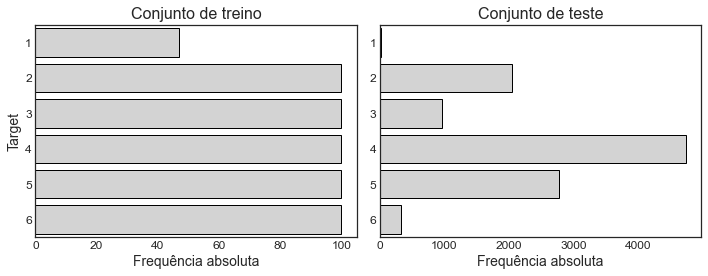

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# gráfico dos dados de treino
sns.countplot(y = 'TARGET', data = train, color = col, edgecolor = ec, ax = axes[0])
axes[0].set_title("Conjunto de treino", size = fs_title)
axes[0].set_xlabel("Frequência absoluta", size = 14)
axes[0].set_ylabel("Target", size = 14)

# gráfico dos dados de teste
sns.countplot(y = 'TARGET', data = test, color = col, edgecolor = ec, ax = axes[1])
axes[1].set_title("Conjunto de teste", size = fs_title)
axes[1].set_xlabel("Frequência absoluta", size = 14)
axes[1].set_ylabel("")

plt.tight_layout()

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_01.png", dpi = 300);

<p>
    <b>Figura 01:</b> Frequência de ocorrências por unidade litoestratigráfica. Conjuntos de treino (esquerda) e teste (direita).
</p>

> Apenas a unidade 1 (Complexo Granito-Gnáissico) apresenta um número de exemplos inferior a `samp_per_class`, quando `samp_per_class = 100`. Nesse sentido, como `threshold = 0.7`, 70% de seus exemplos foram aleatoriamente amostrados para compor o conjunto de treino.

> A heurística adotada para a separação entre os conjuntos de treino e teste mitiga o desbalanceamento de classes identificado no [notebook1](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/notebook1.ipynb).

> A distribuição das classes nos conjuntos de treino e teste são distintas.

### Visualização espacial dos dados de treino e teste

A *Figura 02* apresenta a distribuição espacial dos dados após a divisão entre os conjuntos de treino (esquerda) e teste (direita).

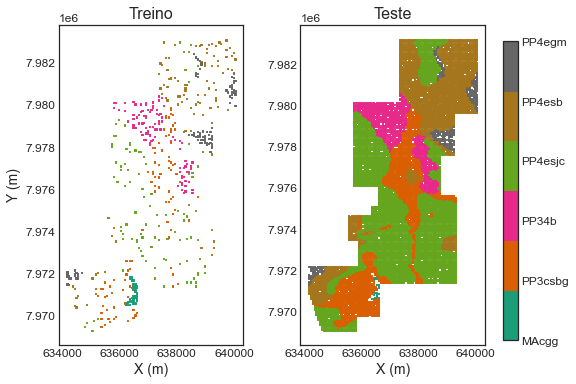

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5.5))

# Mapa de localização dos exemplos de treino
p1 = ax1.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
ax1.set_title('Treino', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)

# Mapa de localização dos exemplos de teste
p2 = ax2.scatter(data = test, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
cbar = fig.colorbar(p2, ax = ax2, use_gridspec = False, anchor = (7, 0))
cbar.ax.set_yticklabels(['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm'])
ax2.set_title('Teste', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)

plt.tight_layout()

# salva mapas
if save_plots:
    plt.savefig("figures/notebook2/Figura_02.png", dpi = 300);

<p>
    <b>Figura 02:</b> Mapas de localização dos exemplos de treino (esquerda) e teste (direita).
</p>

> Embora não haja nenhuma restrição espacial implementada na divisão entre os conjuntos de treino e teste, nota-se que o conjunto de treino apresenta exemplos por toda a extensão da área. Isso se deve ao fato de a separação dos dados ser condicionada às unidades litoestratigráficas que, por sua vez, apresentam interdependência espacial.

<a id='4'></a>
## Pré-processamento

Nesta seção, são apresentadas todas as etapas de **pré-processamento** dos dados que antecedem o treinamento do classificador. O pré-processamento consiste em uma das etapas mais complexas do fluxo de trabalho de Aprendizado de Máquina. As etapas utilizadas neste projeto são:

1. Escalonamento das features

2. Redução da dimensionalidade

3. Seleção das features

4. Superamostragem

Definidas as etapas de pré-processamento, elas serão encadeadas em uma estrutura denominada **pipeline** para tornar o fluxo de trabalho mais simples e automatizado.

### Escalonamento das features

O **escalonamento de features** pode ser uma importante etapa para diversos algoritmos de Aprendizado de Máquina. Além disso, alguns classificadores, como *Support Vector Machines* e *K-Nearest Neighbors*, exigem que as features estejam estandardizadas antes do treinamento.

Nesse sentido, como as features disponíveis apresentam escalas distintas e alguns algoritmos requerem a estandardização pré-treinamento, a primeira etapa de pré-processamento é a **estandardização (normalização Z-score)**.

Considere $x^{(i)}$ um valor assumido por uma feature $x_{(i)}$, $\mu_{(i)}$ a média da feature $x_{(i)}$ e $\sigma_{(i)}$ o desvio padrão da feature $x_{(i)}$. A estandardização transforma os valores originais $x^{(i)}$ das features em scores padrão $z^{(i)}$. A variável estandardizada $z_{(i)}$ segue a Distribuição Normal Padrão ($z_{(i)}\sim N(0,1)$):

<p style="text-align:center; font-size:20px">
    $z^{(i)} =\frac{x^{(i)}-\mu_{(i)}}{\sigma_{(i)}}$
</p>

In [11]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)

In [12]:
# Visualização das features escalonadas do conjunto de treino
pd.DataFrame(X_train_std, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,1.925042,0.294877,-0.315957,0.403014,0.080342,-0.570957,-0.613666,0.396018,-1.647478,-0.883643,...,-0.850956,-1.029210,-0.176277,-1.145369,-1.322683,-0.841989,-1.003773,-0.236750,1.247100,0.781578
1,-0.697592,-0.635175,1.709698,0.444511,0.357349,0.317860,1.654651,-1.175458,1.617799,-0.824130,...,-0.769237,-0.242417,-1.150729,-0.209394,-0.339503,-0.387236,0.658618,-0.965742,-0.301601,0.001767
2,0.564241,-0.305536,-0.422973,-0.316259,-0.462130,-0.272755,-0.446748,0.275135,-0.916880,-0.297013,...,-0.188918,-0.149952,-0.358138,0.092082,-0.017206,-0.427049,-0.528804,-0.008940,0.417998,0.086529
3,-0.669770,-0.258445,-0.945312,-0.583681,-0.519840,-0.382771,-0.247575,0.275135,1.040786,0.796330,...,0.963430,0.825973,0.468382,1.079967,1.151339,1.176975,3.587592,-0.282312,-0.817835,-0.540711
4,0.026334,-0.529220,-0.774596,-0.431527,-0.773763,-0.269859,-0.387077,-0.027072,-2.231456,-0.589478,...,-0.489737,-0.468536,-0.174241,-0.208596,-0.240436,-0.809254,-2.349518,-0.540497,-1.662581,-0.676330


### Redução da dimensionalidade

A **maldição da dimensionalidade** consiste em diversos fenômenos que ocorrem quando se lida com dados de elevada dimensionalidade (i.e. múltiplas features). Um dos principais problemas diz respeito ao fato de que quando as dimensões do espaço de features aumentam, os dados tendem a se tornar esparsos rapidamente.

Uma das abordagens mais comuns no que se refere à redução de dimensionalidade é a **Análise de Componentes Principais (PCA)**. A PCA consiste em uma técnica estatística multivariada que visa a transformação de um conjunto de features originais em um outro conjunto de features denominadas **componentes principais**. As componentes principais são, por definição, ortogonais entre si no espaço de features.

Como as features Landsat apresentam fortes correlações lineares entre si, a segunda etapa de pré-processamento consistirá na aplicação dessa técnica sobre tais sensores, objetivando a redução do número de informações redundantes.

In [13]:
# Obtenção das componentes principais
pca = PCA(n_components = 12)
pcs = pca.fit_transform(X_train_std[:, np.arange(9,21)])

A *Figura 03* apresenta um gráfico de variância explicada relativa por cada uma das doze componentes principais.

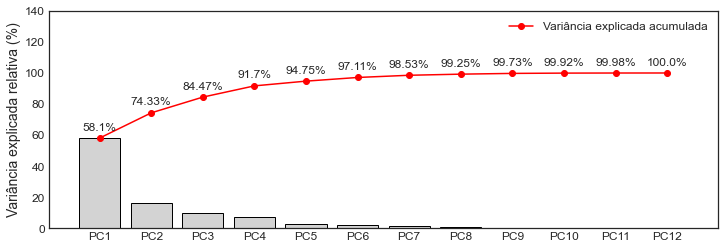

In [14]:
# variância explicada relativa de cada componente principal
explained_var = (pca.explained_variance_ratio_ * 100).round(3)
# variância explicada relativa acumulada
cum_explained_var = np.cumsum(explained_var).round(2)
# labels das componentes principais
pc_names = ['PC' + str(i) for i in range(1,13)]

# gráfico de barras de componentes principais
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(111)
plt.bar(x = pc_names, height = explained_var, color = 'lightgray', edgecolor = ec)
plt.ylabel("Variância explicada relativa (%)", size = 14)

# gráfico de linha de variâncias acumuladas
ax2 = fig.add_subplot(111)
plt.plot(pc_names, cum_explained_var, color = 'red', marker = 'o', label = 'Variância explicada acumulada')
plt.yticks(np.arange(0,160,20))
plt.legend(loc = 'top right')

for i, v in enumerate(cum_explained_var):
    ax2.text(i, v + 5, str(v) + '%', ha = 'center', size = 12)
    
# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_03.png", dpi = 300);

<p>
    <b>Figura 03:</b> Variância explicada relativa para cada uma das doze componentes principais.
</p>

> Nota-se que apenas as cinco primeiras componentes principais explicam ~95% da variância presente nas doze bandas Landsat.

> Portanto, o número inicial de bandas Landsat será reduzido de doze para apenas cinco componentes principais.

Após a aplicação da PCA sobre as bandas Landsat e a obtenção de um resultado satisfatório no que diz respeito à variância explicada pelas cinco primeiras componentes principais, a PCA personalizada pode ser realizada. A classe [MaskedPCA](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Preprocessing.py) permite que a técnica seja realizada apenas sobre as features Landsat, retornando as cinco primeiras componentes principais, além das demais features não envolvidas na redução da dimensionalidade.

In [15]:
# instanciação do objeto MaskedPCA
mask = np.arange(9,21)
masked_pca = MaskedPCA(n_components = 5, mask = mask)

# treinamento e transformação dos dados de treino
X_train_pca = masked_pca.fit_transform(X_train_std)
print(f'Dimensões das features de treino (pré-PCA) = {X_train_std.shape}')
print(f'Dimensões das features de treino (pós-PCA) = {X_train_pca.shape}\n')

Dimensões das features de treino (pré-PCA) = (547, 21)
Dimensões das features de treino (pós-PCA) = (547, 14)



> Como as doze bandas Landsat foram redimensionadas para as cinco primeiras componentes principais, após a PCA, o número de features total reduzirá de 21 para 14.

Após a aplicação da PCA, uma matriz é calculada, objetivando a análise das correlações lineares entre as novas features (*Figura 04*).

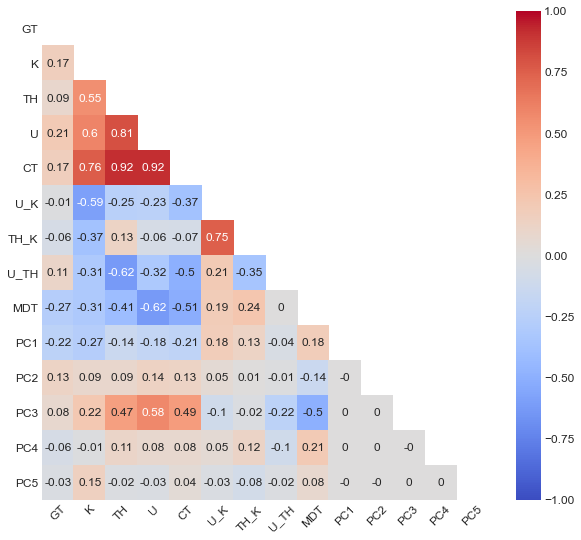

In [16]:
PCA_FEAT = list(FEAT[:9]) + pc_names[:5]
df_X_train_pca = pd.DataFrame(X_train_pca, columns = PCA_FEAT)

# Matriz de correlação linear
pca_corr = df_X_train_pca.corr(method = 'pearson').round(2)

# heatmap de correlação linear
plt.figure(figsize = (10, 9))
mask = np.triu(np.ones_like(pca_corr, dtype = np.bool))
ax = sns.heatmap(
                 pca_corr, annot = True,
                 cmap = 'coolwarm', cbar = True,
                 mask = mask, vmin = -1.0, vmax = 1.0
                )
ax.set_xticklabels(PCA_FEAT, rotation = 45)
ax.set_yticklabels(PCA_FEAT, rotation = 0)

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_04.png", dpi = 300);

<p>
    <b>Figura 04:</b> Matriz de correlação linear entre as novas features (pós-PCA).
</p>

> Nota-se que, após a redução da dimensionalidade dos sensores Landsat, houve uma redução do número de features que apresentavam forte correlação linear entre si.

> A feature `CT` apresenta forte correlação linear positiva com os canais radiométricos (i.e. `U`, `TH` e `K`).

> As features `U_K` e `TH_K` apresentam forte correlação linear positiva entre si.

> As features `U` e `TH` apresentam forte correlação linear positiva entre si, o que já era esperado, uma vez que ambos pertencem à mesma cadeia de decaimento radioativo.

> Nota-se uma ausência de correlação linear entre as cinco primeiras componentes principais, conforme esperado.

### Seleção de features

A **seleção de features** consiste na identificação e seleção de um subconjunto de features que são julgadas como mais relevantes para a predição das classes.

Essa etapa normalmente é simples quando tanto as features quanto o target são variáveis numéricas. Entretanto, quando as features são numéricas mas o target é categórico, esse procedimento tende a ser mais complexo.

A heurística Teste F ANOVA é utilizada neste trabalho para realizar a seleção de features, uma vez que essa técnica é comumente adotada em um contexto de features numéricas e target categórico.

#### Teste F ANOVA

A **Análise de Variância (ANOVA)** consiste em um teste de hipótese paramétrico que determina se as médias de dois ou mais conjuntos de dados seguem a mesma distribuição ou não.

A estatística de teste, **estatística F**, consiste na razão entre as variâncias dos conjuntos de dados:

<p style="text-align:center; font-size:20px">
    $F = \frac{\sigma_{(i)}}{\sigma_{(j)}}$
</p>

A função auxiliar [univariateSelector](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Preprocessing.py) foi implementada para calcular os scores de importância do método Teste F ANOVA. Já a função [plotSelectionScores](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Preprocessing.py) é utilizada para plotar os scores de importância de cada uma das features em ordem decrescente.

A *Figura 05* ilustra os scores de importância das features pela técnica de seleção Teste F ANOVA.

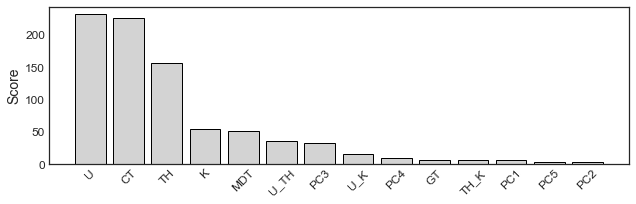

In [17]:
X_train_anova, anova_scores = univariateSelector(X_train_pca, y_train, f_classif)
plotSelectionScores(anova_scores, PCA_FEAT, col = col, ec = ec)

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_05.png", dpi = 300);

<p>
    <b>Figura 05:</b> Scores de importância das features pela técnica de seleção Teste F ANOVA.
</p>

> De acordo com os scores, as features mais importantes são os canais radiométricos. Essa hipótese já havia sido formulada durante a análise dos boxplots no [notebook1](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/notebook1.ipynb).

> Apenas as 10 features mais importantes serão selecionadas para o treinamento do classificador. Isso soluciona o problema da elevada correlação entre as features `TH_K` e `U_K`, já que a primeira será descartada em função de seu baixo score.

De acordo com a matriz de correlação linear apresentada anteriormente (*Figura 04*), a feature `CT` apresenta uma forte correlação linear positiva com os três canais radiométricos e, portanto, será removida para reduzir o número de informações redundantes.

As features `U` e `TH`, embora apresentem forte correlação linear positiva, não serão removidas, uma vez que fornecem informações químicas importantes para a identificação das unidades litoestratigráficas.

In [18]:
# Exclusão da feature CT
df.drop(['CT'], axis = 1, inplace = True)

# Atualização da lista de features após exclusão
FEAT = ['GT','K','TH','U','U_K','TH_K','U_TH','MDT','B01','B02','B03',
        'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'R', 'G', 'B']

### Superamostragem

Um conjunto de dados é considerado desbalanceado, quando a frequência de ocorrência de suas classes é nitidamente desigual. Esse é o caso dos dados deste projeto, conforme evidenciado no [notebook1](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/notebook1.ipynb). Esse tipo de situação normalmente provoca um enviesamento do classificador que, por sua vez, tende a prever mais exemplos da classe majoritária.

Ainda que a heurística adotada para a divisão entre treino e teste mitigue o desbalanceamento de classes no conjunto de treino, nota-se que a unidade 1 (i.e. Complexo Granito-Gnáissico) ainda é minoritária quando comparada com as demais classes no conjunto de treino (*Figura 01*).

Nesse sentido, a última etapa de pré-processamento adotada consiste na superamostragem da classe minoritária pela **Synthetic Minority Oversampling Technique (SMOTE)**.

A SMOTE, primeiramente, seleciona os $k$ exemplos mais próximos de um exemplo minoritário, de modo que o conceito de distância, nesse caso, se refere ao espaço de features. Em seguida, uma linha imaginária é desenhada ligando os $k$ exemplos mais próximos selecionados. Por fim, um exemplo sintético é gerado a partir da seleção de um ponto aleatório que pertença à linha imaginária construída anteriormente.

A *Figura 06* ilustra a frequência de ocorrência das unidades litoestratigráficas após a aplicação da SMOTE.

In [19]:
# Aplicação da SMOTE
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train_anova, y_train)

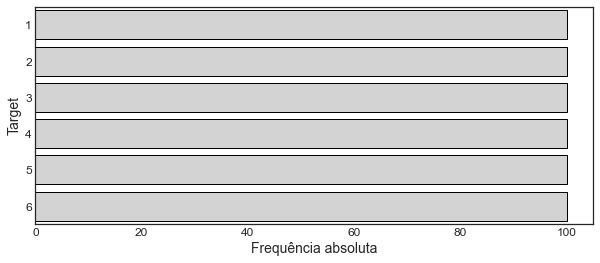

In [20]:
# transformação de narray em dataframe
train_smt = pd.DataFrame(X_train_smt, columns = PCA_FEAT)
train_smt['TARGET'] = y_train_smt

# gráfico de barras
plt.figure(figsize = (10,4))

sns.countplot(y = 'TARGET', data = train_smt, color = col, edgecolor = ec)

plt.xlabel("Frequência absoluta", size = 14)
plt.ylabel("Target", size = 14)

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_06.png", dpi = 300);

<p>
    <b>Figura 06:</b> Frequência de ocorrência dos exemplos do conjunto de treino por unidade, após a aplicação da técnica SMOTE.
</p>

> A aplicação da SMOTE torna o conjunto de treino balanceado.

> Como havia apenas 47 instâncias do Complexo Granito-Gnáissico (unidade 1) no conjunto de treino, a SMOTE estimou 53 amostras sintéticas, totalizando 100 amostras.

<a id='5'></a>
## Transformadores e variáveis

Neste tópico são definidos os principais transformadores e variáveis do fluxo de trabalho apresentado a seguir. Os **transformadores** são os objetos utilizados nas etapas de pré-processamento. Já as **variáveis** são parâmetros cruciais para o desenvolvimento do fluxo de trabalho.

In [21]:
# número de exemplos de treino por unidade
nb_eg = 100

# método de escalonamento de features
scaler = StandardScaler()

# PCA personalizada
mask = np.arange(8,20)
dim_reduction = MaskedPCA(n_components = 5, mask = mask)

# número de features a serem selecionadas
nb_features = 10

# método de seleção de features
selector = SelectKBest(score_func = f_classif, k = nb_features)

# método de oversampling
oversamp = SMOTE(random_state = 42)

# número de folds da validação cruzada
n_folds = 5

# validação cruzada
cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# métrica de performance
metric = 'f1_weighted'

<a id='6'></a>
## Divisão entre treino e teste

Com as etapas de pré-processamento devidamente definidas, os dados são novamente separados entre dois conjuntos: treino e teste.

O conjunto de **treino** é obtido a partir da amostragem aleatória de `nb_eg = 100` exemplos por unidade litoestratigráfica, assim como discutido anteriormente. Esses dados serão utilizados para treinar os classificadores selecionados.

O conjunto de **teste** é constituído pelos exemplos que não pertencem aos dados de treino. Essas instâncias não são acessadas pelo classificador e, por isso, serão utilizadas para avaliar sua performance.

In [22]:
X_train, y_train, X_test, y_test = customTrainTestSplit(df, FEAT, COORD,
                                                        samp_per_class = nb_eg,
                                                        threshold = 0.7)

print(f"Treino: X {X_train.shape}, y {y_train.shape}")
print(f"Teste: X {X_test.shape}, y {y_test.shape}")

Treino: X (547, 20), y (547,)
Teste: X (10871, 20), y (10871,)


<a id='7'></a>
## Criação dos pipelines

Após a definição das etapas de pré-processamento, elas podem ser encadeadas nos chamados **pipelines**. Os pipelines são objetos que automatizam fluxos de trabalho bem definidos. No caso, eles englobarão desde a etapa de escalonamento das features até a instanciação do classificador:

1. Estandardização das features
2. Redução da dimensionalidade dos sensores Landsat
3. Seleção das 10 features mais importantes
4. Superamostragem
5. Instanciação do classificador

Como um dos objetivos so trabalho é comparar a performance entre diferentes classificadores, será criado um pipeline por algoritmo. Desse modo, os **classificadores** avaliados neste projeto são:
- *Multinomial Logistic Regression (MLR)*
- *Decision Tree (DT)*
- *Gaussian Naive Bayes (GNB)*
- *K-Nearest Neighbor (KNN)*
- *Support Vector Machines (SVM)*
- *Random Forest (RF)*
- *XGBoost (XGB)*
- *Multilayer Perceptron (MLP)*

In [23]:
# MLR
mlr_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', LogisticRegression(multi_class = 'multinomial', penalty = 'l2'))])

# DT
dt_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', DecisionTreeClassifier(random_state = 42))])

# GNB
gnb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',GaussianNB(priors = [0.006,0.188,0.093,0.423,0.252,0.038]))])

# KNN
knn_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',KNeighborsClassifier())])

# SVM
svm_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', SVC(random_state = 42))])

# RF
rf_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', RandomForestClassifier(random_state = 42))])

# XGB
xgb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', XGBClassifier(eval_metric = 'mlogloss', verbosity = 0, random_state = 42))])

# MLP
mlp_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', MLPClassifier(random_state = 42))])

pipe = {"MLR" : mlr_pipe,
        "DT"  : dt_pipe,
        "GNB" : gnb_pipe,
        "KNN" : knn_pipe,
        "SVM" : svm_pipe,
        "RF"  : rf_pipe,
        "XGB" : xgb_pipe,
        "MLP" : mlp_pipe}

<a id='8'></a>
## Tuning dos hiperparâmetros

Em geral, os algoritmos de aprendizado apresentam parâmetros e hiperparâmetros.

Os **parâmetros** são os coeficientes encontrados para o modelo durante a etapa de aprendizado do algoritmo. Nesse sentido, o objetivo do aprendizado é justamente encontrar os valores ótimos para os parâmetros em relação à performance do modelo. Consequentemente, os parâmetros são definidos em função dos dados de treino.

Por outro lado, os **hiperparâmetros** são propriedades intrínsecas dos algoritmos de aprendizado e que não podem ser otimizados durante a etapa de treinamento. A definição dos valores dos hiperparâmetros impacta diretamente a maneira de funcionamento dos algoritmos e, portanto, é essencial no que diz respeito à performance do modelo.

Como os hiperparâmetros não são otimizados durante a etapa de treinamento, é necessário encontrar empiricamente a melhor combinação de valores para os hiperparâmetros. Esse procedimento é chamado de **tuning dos hiperparâmetros**. Neste projeto serão utilizadas duas abordagens distintas: Grid Search e Random Search.

O **Grid Search** consiste no treinamento de $n$ modelos, sendo $n$ igual ao número de possíveis combinações entre os hiperparâmetros definidos. Esse método é mais utilizado quando o número de hiperparâmetros e o tempo de treinamento do algoritmo em questão são pequenos.

Por outro lado, na técnica **Random Search**, além de se informar um número discreto de valores para cada hiperparâmetro, pode-se, alternativamente, definir uma distribuição estatística da qual os potenciais candidatos a cada um dos hiperparâmetros são aleatoriamente amostrados. Nesse caso, ao invés de se testar todas as combinações entre os valores de hiperparâmetros, um número fixo de iterações $i$ deve ser definido. Esse método tende a ser mais utilizado quando o algoritmo em questão apresenta um grande número de hiperparâmetros e um maior tempo de treinamento.

Abaixo, é definido um dicionário de valores candidatos a hiperparâmetros para cada um dos oito algoritmos escolhidos.

In [24]:
# MLR
mlr_param = [{'clf__solver'  : ['newton-cg','saga','sag','lbfgs'],
              'clf__C'       : np.logspace(-3,3,10)}]

# DT
dt_param = [{'clf__criterion'         : ['gini','entropy'],
             'clf__max_depth'         : [15,25,30,None],
             'clf__min_samples_split' : [1,2,5,10],
             'clf__min_samples_leaf'  : [1,2,5,10]}]

# GNB
gnb_param = [{'clf__var_smoothing' : np.logspace(-10,0,11)}]

# KNN
knn_param = [{'clf__n_neighbors'  : [i for i in range(3,30) if i % 2 != 0],
              'clf__weights'      : ['uniform', 'distance'],
              'clf__p'            : [1,2]}]

# SVM
svm_param = [{'clf__C'      : np.logspace(-3,3,10),
              'clf__gamma'  : [0.001, 0.01, 0.1, 1, 10, 100, 'auto'],
              'clf__kernel' : ['poly', 'rbf']}]

# RF
rf_param = [{'clf__n_estimators'      : [25,50,100,500],
             'clf__max_depth'         : [15,25,30,None],
             'clf__criterion'         : ['gini', 'entropy'],
             'clf__min_samples_split' : [1,2,5,10],
             'clf__min_samples_leaf'  : [1,2,5,10]}]

# XGB
xgb_param = [{'clf__eta'               : [0.01,0.015,0.025,0.05,0.1],
              'clf__learning_rate'     : [0.1,0.15,0.2,0.25,0.3,0.35,0.4],
              'clf__gamma'             : [0.05,0.1,0.3,0.4,0.5,0.7,0.9,1.0],
              'clf__max_depth'         : [3,5,7,9,12,15,17,25],
              'clf__min_child_weight'  : [1,3,5,7],
              'clf__subsample'         : [0.6,0.7,0.8,0.9,1.0],
              'clf__colsample_bytree'  : [0.6,0.7,0.8,0.9,1.0],
              'clf__reg_lambda'        : [10 ** i for i in range(-3,4)],
              'clf__alpha'             : [10 ** i for i in range(-3,4)]}]

# MLP
mlp_param = [{'clf__hidden_layer_sizes' : [(10,),(20,),(30,),(50,),(10,10),(20,20),(10,10,10),(10,30,10),(20,20,20)],
              'clf__activation'         : ['logistic','tanh','relu'],
              'clf__solver'             : ['lbfgs','sgd','adam'],
              'clf__alpha'              : [10 ** i for i in range(-3,4)],
              'clf__learning_rate'      : ['constant','adaptive'],
              'clf__learning_rate_init' : [0.0001,0.001,0.01,0.1,0.15,0.2,0.25,0.3],
              'clf__max_iter'           : [1,5,10,20,50,80,100,150,200,250]}]

param = [mlr_param, dt_param, gnb_param, knn_param, svm_param, rf_param, xgb_param, mlp_param]

dic_param = {}
for k, p in zip(pipe.keys(), param):
    dic_param[k] = p

Definidos os possíveis valores de hiperparâmetros para cada um dos modelos, inicia-se o procedimento de tuning dos hiperparâmetros.

O método **Grid Search** será utilizado no caso dos modelos mais simples (i.e. pequeno número de hiperparâmetros) e com menor tempo de treinamento:

- *Multinomial Logistic Regression (MLR)*
- *Decision Tree (DT)*
- *Gaussian Naive Bayes (GNB)*
- *K-Nearest Neighbor (KNN)*
- *Support Vector Machines (SVM)*

Já a técnica **Random Search** é aplicada no caso de algoritmos mais complexos (i.e. grande número de hiperparâmetros) e com maior tempo de treinamento:

- *Random Forest (RF)*
- *XGBoost (XGB)*
- *Multilayer Perceptron (MLP)*

Na célula abaixo, o procedimento de tuning dos hiperparâmetros é realizado para cada um dos modelos de acordo com os critérios anteriormente definidos e baseado na métrica **F1-Score**. As melhores configurações de hiperparâmetros serão utilizadas nas posteriores etapas de validação cruzada e treinamento.

In [25]:
best_params = []

# grid search
for m in ['MLR', 'DT', 'GNB', 'KNN', 'SVM']:
    grid = GridSearchCV(pipe[m], param_grid = dic_param[m], cv = cv, scoring = metric)
    grid.fit(X_train, y_train)
    best_params.append(grid.best_params_)
    print("----")
    print(m)
    print("Melhores parâmetros:", grid.best_params_)
    print('{0} = {1}'.format(metric, round(grid.best_score_, 3)))
    
# random search
for m in ['RF', 'XGB', 'MLP']:
    # random search
    random = RandomizedSearchCV(pipe[m], param_distributions = dic_param[m], cv = cv,
                                scoring = metric, n_iter = 50, random_state = 42)
    random.fit(X_train, y_train)
    best_params.append(random.best_params_)
    print("----")
    print(m)
    print("Melhores parâmetros:", random.best_params_)
    print('{0} = {1}'.format(metric, round(random.best_score_, 3)))

----
MLR
Melhores parâmetros: {'clf__C': 10.0, 'clf__solver': 'newton-cg'}
f1_weighted = 0.574
----
DT
Melhores parâmetros: {'clf__criterion': 'entropy', 'clf__max_depth': 25, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}
f1_weighted = 0.605
----
GNB
Melhores parâmetros: {'clf__var_smoothing': 1e-05}
f1_weighted = 0.54
----
KNN
Melhores parâmetros: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
f1_weighted = 0.675
----
SVM
Melhores parâmetros: {'clf__C': 10.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
f1_weighted = 0.639
----
RF
Melhores parâmetros: {'clf__n_estimators': 50, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 25, 'clf__criterion': 'entropy'}
f1_weighted = 0.699
----
XGB
Melhores parâmetros: {'clf__subsample': 0.9, 'clf__reg_lambda': 0.001, 'clf__min_child_weight': 1, 'clf__max_depth': 12, 'clf__learning_rate': 0.15, 'clf__gamma': 0.9, 'clf__eta': 0.05, 'clf__colsample_bytree': 0.9, 'clf__alpha': 0.01}
f1_weighted = 0.6

<a id='9'></a>
## Validação cruzada

Em situações cujo conjunto de treino contém poucas amostras, como é o caso, é comum não ser possível separar os dados em três conjuntos (i.e. treino, validação e teste), mas sim em apenas dois (i.e. treino e teste). Quando isso ocorre, é necessária a aplicação de uma técnica para se obter a estimativa do erro de generalização do modelo, como, por exemplo, a Validação Cruzada K-Fold.

A **Validação Cruzada K-Fold** consiste na separação aleatória do conjunto de treino em $k$ subconjuntos mutualmente excludentes e de mesmo tamanho chamados **folds**. A cada iteração $i$, um dos subconjuntos é designado para **validação** e os $k-1$ demais subconjuntos são utilizados para treinar o algoritmo de aprendizado, e, em seguida, a métrica de interesse é computada. Ao final das $k$ iterações, a métrica final é obtida a partir da média entre os $k$ scores computados.

A Validação Cruzada K-Fold, por ser um estimador do erro de generalização, é comumente utilizada para selecionar o modelo de melhor performance. Esse estimador assume algumas premissas, como: 

1. Os exemplos são oriundos de variáveis aleatórias independentes e identicamente distribuídas (i.i.d.).

2. A função de predição dos labels do conjunto de treino é igual à do conjunto de teste. Portanto, não pode haver um *shift* na distribuição bivariada das features entre os conjuntos de treino e teste.

Como todas as features utilizadas representam fenômenos geoespaciais e consequentemente mostram interdependência espacial, a primeira premissa é quebrada. Desse modo, um dos objetivos desse projeto é verificar se a Validação Cruzada K-Fold ainda sim fornece uma estimativa razoável para o erro de generalização e se ela é capaz de selecionar corretamente o modelo de melhor performance.

Um classificador dummy é instanciado com a função de **baseline** para o projeto. Esse classificador prediz sempre a Formação São João da Chapada (unidade 4), ou seja, a unidade que mais aflora na área.

Inicialmente, cada um dos classificadores é treinado com os hiperparâmetros selecionados durante a etapa de tuning.

In [26]:
# baseline
dummy = Pipeline(steps = [('clf', DummyClassifier(strategy = "constant", constant = 4))])

# MLR
mlr = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', LogisticRegression(C = best_params[0]['clf__C'],
                                                   solver = best_params[0]['clf__solver'],
                                                   multi_class = 'multinomial',
                                                   penalty = 'l2'))])

# DT
dt = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', DecisionTreeClassifier(criterion = best_params[1]['clf__criterion'],
                                                      max_depth = best_params[1]['clf__max_depth'],
                                                      min_samples_split = best_params[1]['clf__min_samples_split'],
                                                      min_samples_leaf = best_params[1]['clf__min_samples_leaf'],
                                                      random_state = 42))])

# GNB
gnb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', GaussianNB(var_smoothing = best_params[2]['clf__var_smoothing'],
                                           priors = [0.006,0.188,0.093,0.423,0.252,0.038]))])

# KNN
knn = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', KNeighborsClassifier(n_neighbors = best_params[3]['clf__n_neighbors'],
                                                     p = best_params[3]['clf__p'],
                                                     weights = best_params[3]['clf__weights']))])

# SVM
svm = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', SVC(C = best_params[4]['clf__C'],
                                    gamma = best_params[4]['clf__gamma'],
                                    kernel = best_params[4]['clf__kernel'],
                                    random_state = 42))])

# RF
rf = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', RandomForestClassifier(n_estimators = best_params[5]['clf__n_estimators'],
                                                      min_samples_split = best_params[5]['clf__min_samples_split'],
                                                      min_samples_leaf = best_params[5]['clf__min_samples_leaf'],
                                                      max_depth = best_params[5]['clf__max_depth'],
                                                      criterion = best_params[5]['clf__criterion'],
                                                      random_state = 42))])

# XGB
xgb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', XGBClassifier(subsample = best_params[6]['clf__subsample'],
                                              reg_lambda = best_params[6]['clf__reg_lambda'],
                                              min_child_weight = best_params[6]['clf__min_child_weight'],
                                              max_depth = best_params[6]['clf__max_depth'],
                                              learning_rate = best_params[6]['clf__learning_rate'],
                                              gamma = best_params[6]['clf__gamma'], 
                                              eta = best_params[6]['clf__eta'],
                                              colsample_bytree = best_params[6]['clf__colsample_bytree'],
                                              alpha = best_params[6]['clf__alpha'],
                                              random_state = 42))])

# MLP
mlp = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', MLPClassifier(hidden_layer_sizes = best_params[7]['clf__hidden_layer_sizes'],
                                              activation = best_params[7]['clf__activation'],
                                              solver = best_params[7]['clf__solver'],
                                              alpha = best_params[7]['clf__alpha'],
                                              learning_rate = best_params[7]['clf__learning_rate'],
                                              learning_rate_init = best_params[7]['clf__learning_rate_init'], 
                                              max_iter = best_params[7]['clf__max_iter'],
                                              random_state = 42))])

tuned_models = {"DUMMY" : dummy,
                "MLR"   : mlr,
                "DT"    : dt,
                "GNB"   : gnb,
                "KNN"   : knn,
                "SVM"   : svm,
                "RF"    : rf,
                "XGB"   : xgb,
                "MLP"   : mlp}

Definidos os pipelines com os melhores hiperparâmetros, pode-se realizar a Validação Cruzada K-Fold. As métricas avaliadas para cada um dos modelos são:

1. Acurácia
2. Precisão
3. Recall
4. F1-Score

Se tratando de uma tarefa de classificação multinomial, as métricas acima (exceto acurácia) são computadas para cada uma das unidades litoestratigráficas. Nesse sentido, o report abaixo contém a média desses scores ponderada pelo número de exemplos de cada uma das unidades.

A função auxiliar [validationReport](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Validation.py) calcula e retorna o report de validação cruzada.

In [27]:
val_report = validationReport(tuned_models, X_train, y_train, cv)
val_report

,DUMMY,MLR,DT,GNB,KNN,SVM,RF,XGB,MLP
f1_weighted,0.057,0.574,0.605,0.540,0.675,0.639,0.699,0.690,0.671
precision_weighted,0.033,0.580,0.607,0.563,0.691,0.648,0.704,0.694,0.679
recall_weighted,0.183,0.579,0.611,0.543,0.682,0.647,0.704,0.693,0.671
accuracy,0.183,0.579,0.611,0.543,0.682,0.647,0.704,0.693,0.671


A  função auxiliar [plotModelScores](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Validation.py) organiza os modelos em ordem decrescente de acordo com suas respectivas performances na validação cruzada (*Figura 07*). O eixo vertical representa a média das métricas computadas por cada um dos modelos.

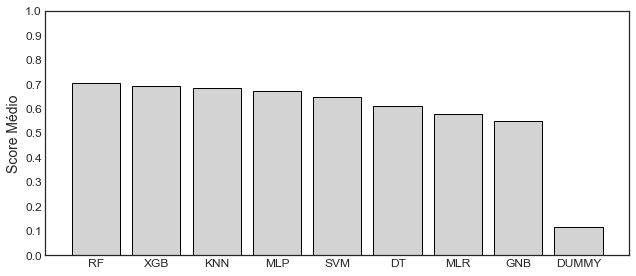

In [28]:
plotModelScores(val_report, list(tuned_models.keys()), col = col, ec = ec)

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_07_.png", dpi = 300);

<p>
    <b>Figura 07:</b> Modelos organizados em ordem decrescente de acordo com a performance na validação cruzada.
</p>

> Os algoritmos de ensemble foram aqueles que apresentaram melhores performances, sendo o *XGBoost* ligeiramente superior ao *Random Forest*.

> Algoritmos simples, como *Multinomial Logistic Regression* e *Gaussian Naive Bayes* apresentaram performances inferiores.

> O algoritmo mais complexo, *Multilayer Perceptron*, obteve performances intermediárias, sendo inferior aos algoritmos de ensemble e superior aos demais classificadores mais simples.

> O classificador *Dummy* apresentou a pior performance, conforme esperado. Ressalta-se que como a Formação São João da Chapada apresenta uma menor frequência relativa nos dados de treino do que no banco de dados, a validação cruzada será pessimista sobre o desempenho desse classificador.

<a id='10'></a>
## Treinamento dos classificadores e predições

Embora o classificador de melhor performance, *XGBoost*, já tenha sido selecionado pela validação cruzada, todos os classificadores serão treinados e suas predições computadas, já que um dos objetivos do trabalho é avaliar o desempenho da Validação Cruzada K-Fold neste tipo de problema geoespacial.

Desse modo, os classificadores serão inicialmente treinados e, em seguida, as predições serão realizadas para os exemplos de teste.

In [29]:
# treinamento
for k in tuned_models.keys():
    tuned_models[k].fit(X_train, y_train)

In [30]:
# predições (conjunto de treino)
ŷ_dummy_train = tuned_models['DUMMY'].predict(X_train)
ŷ_mlr_train   = tuned_models['MLR'].predict(X_train)
ŷ_dt_train    = tuned_models['DT'].predict(X_train)
ŷ_gnb_train   = tuned_models['GNB'].predict(X_train)
ŷ_knn_train   = tuned_models['KNN'].predict(X_train)
ŷ_svm_train   = tuned_models['SVM'].predict(X_train)
ŷ_rf_train    = tuned_models['RF'].predict(X_train)
ŷ_xgb_train   = tuned_models['XGB'].predict(X_train)
ŷ_mlp_train   = tuned_models['MLP'].predict(X_train)

dic_ŷ_train = {'DUMMY' : ŷ_dummy_train,
               'MLR'   : ŷ_mlr_train,
               'DT'    : ŷ_dt_train,
               'GNB'   : ŷ_gnb_train,
               'KNN'   : ŷ_knn_train,
               'SVM'   : ŷ_svm_train,
               'RF'    : ŷ_rf_train,
               'XGB'   : ŷ_xgb_train,
               'MLP'   : ŷ_mlp_train}

In [31]:
# predições (conjunto de teste)
ŷ_dummy_test = tuned_models['DUMMY'].predict(X_test)
ŷ_mlr_test   = tuned_models['MLR'].predict(X_test)
ŷ_dt_test    = tuned_models['DT'].predict(X_test)
ŷ_gnb_test   = tuned_models['GNB'].predict(X_test)
ŷ_knn_test   = tuned_models['KNN'].predict(X_test)
ŷ_svm_test   = tuned_models['SVM'].predict(X_test)
ŷ_rf_test    = tuned_models['RF'].predict(X_test)
ŷ_xgb_test   = tuned_models['XGB'].predict(X_test)
ŷ_mlp_test   = tuned_models['MLP'].predict(X_test)

dic_ŷ_test = {'DUMMY' : ŷ_dummy_test,
              'MLR'   : ŷ_mlr_test,
              'DT'    : ŷ_dt_test,
              'GNB'   : ŷ_gnb_test,
              'KNN'   : ŷ_knn_test,
              'SVM'   : ŷ_svm_test,
              'RF'    : ŷ_rf_test,
              'XGB'   : ŷ_xgb_test,
              'MLP'   : ŷ_mlp_test}

Abaixo, são apresentados os mapas geológicos preditivos para cada um dos oito classificadores. Além disso, o mapa geológico de campo e a localização das inconsistências também são mostrados para facilitar a validação visual dos mapas preditivos gerados.

As funções auxiliares [createPredTable](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Prediction.py) e [createMissClassifTable](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Prediction.py) retornam os dataframes de predições e de inconsistências, respectivamente.

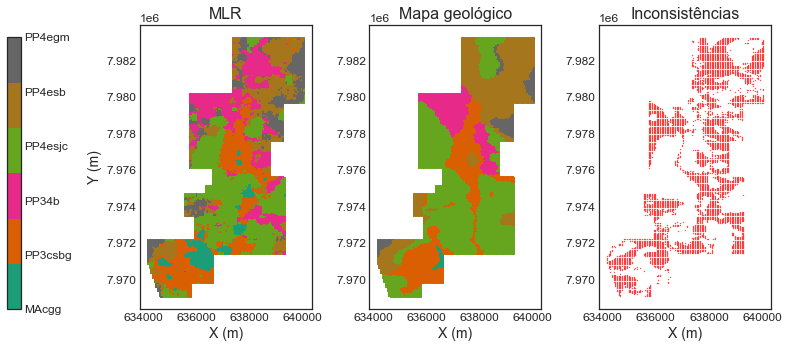

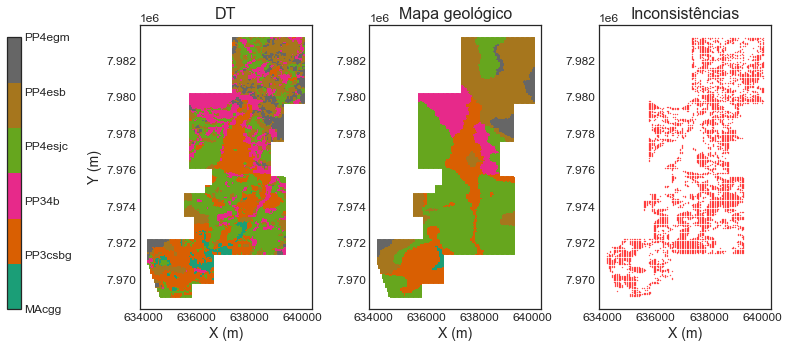

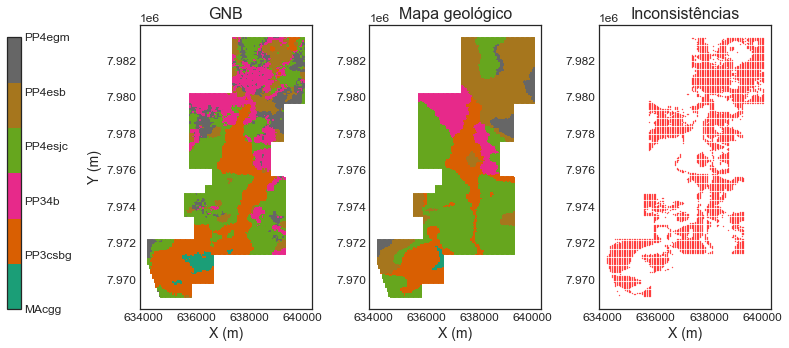

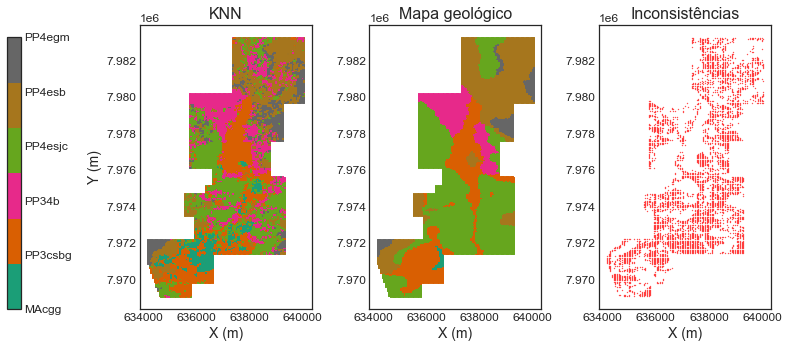

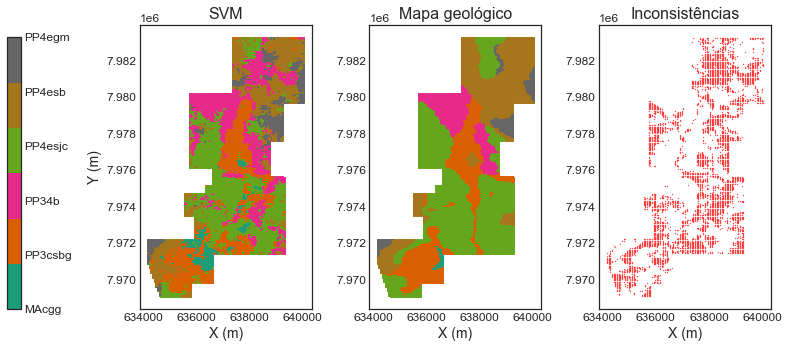

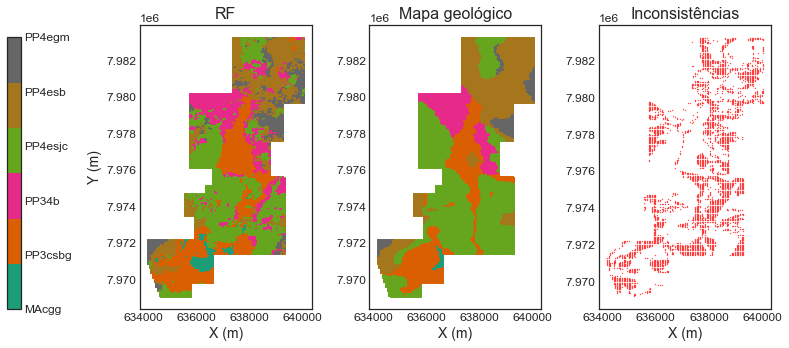

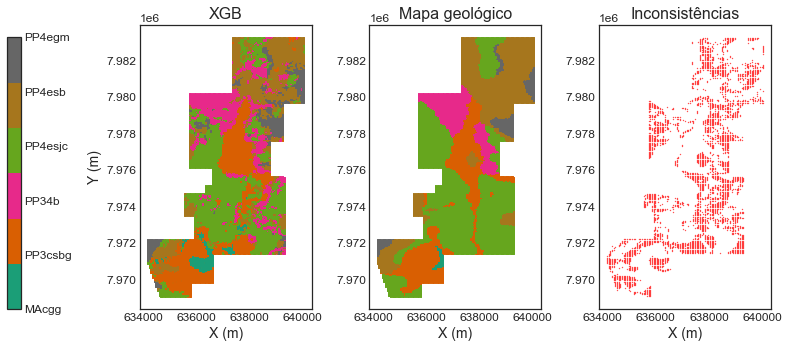

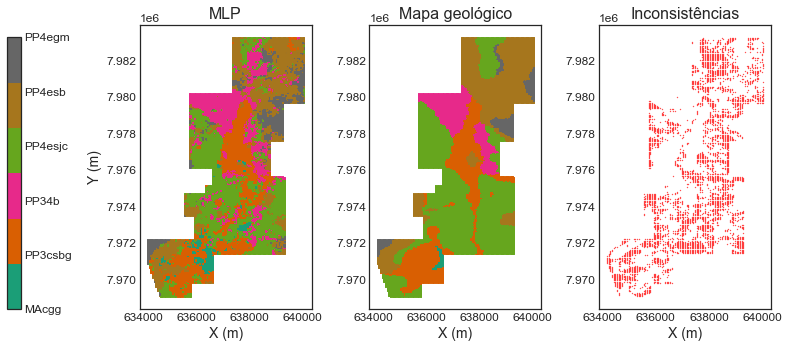

In [32]:
# mapa preditivo
pred_map = createPredTable(dic_ŷ_train, dic_ŷ_test, train, test)
# mapa geológico
geo_map = pd.concat([train,test])
# mapa de inconsistências
miss_map = createMissClassifTable(pred_map, y_train, y_test)
# lista de modelos
models = ['MLR','DT','GNB','KNN','SVM','RF','XGB','MLP']

for model in models:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
    
    # plotagem do mapa preditivo
    cm_map = ax1.scatter(data = pred_map, x = 'X', y = 'Y', c = model, cmap = cm, s = sz, marker = mk)
    ax1.set_title(model, size = fs_title)
    ax1.set_xlabel('X (m)', size = 14)
    ax1.set_ylabel('Y (m)', size = 14)
    
    # plotagem do mapa geológico
    ax2.scatter(data = geo_map, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    ax2.set_title("Mapa geológico", size = fs_title)
    ax2.set_xlabel('X (m)', size = 14)
    
    # plotagem do mapa de inconsistências
    filtered_miss_map = miss_map[miss_map['MISS_' + model] == 1]
    ax3.scatter(data = filtered_miss_map, x = 'X', y = 'Y', c = 'red', s = 0.1, marker = 'o')
    ax3.set_title("Inconsistências", size = fs_title)
    ax3.set_xlabel('X (m)', size = 14)
    
    # legenda de unidades
    cbar = fig.colorbar(cm_map, ax = ax1, use_gridspec = False, anchor = (-27, 0))
    cbar.ax.set_yticklabels(['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm'])
    
    plt.tight_layout()
    
    # salva mapas
    if save_plots:
        plt.savefig("figures/notebook2/Figura_08_"+model+".png", dpi = 300);

<p>
    <b>Figura 08:</b> Comparação entre os mapas geológicos preditivos por modelo e inconsistências entre os mapas geológicos preditivos e o mapa geológico de campo. <i>MLR = Multinomial Logistic Regression, DT = Decision Tree, GNB = Gaussian Naive Bayes, KNN = K-Nearest Neighbors, SVM = Support Vector Machines, RF = Random Forest, XGB = XGBoost, MLP = Multilayer Perceptron.</i>
</p>

> A partir de uma análise visual qualitativa, os mapas preditivos gerados pelos classificadores ensemble apresentaram melhor resultado.

> Embora o modelo *K-Nearest Neighbors (KNN)* apresente a terceira melhor performance de acordo com o report de validação cruzada, seu mapa preditivo evidencia um aspecto altamente *scattered* (ruidoso).

> Todos os mapas preditivos evidenciam um "offset" da Formação Barão de Guaicuí na porção central da área.

<a id='11'></a>
## Avaliação da performance dos modelos

Após a realização das predições para cada um dos modelos, pode-se avaliar a performance de cada um deles no conjunto de teste. Enfatiza-se que não houve qualquer contato entre o conjunto de teste e os classificadores até então.

### Matriz de confusão

A **matriz de confusão** consiste em uma tabela que sumariza o quão bem sucedido foi o classificador na predição de cada uma das classes. Um dos eixos representa as classes reais, ao passo que o outro se refere às classes preditas. Como o problema em questão é do tipo multinomial com 6 classes, as matrizes, para cada um dos modelos, serão 6x6.

A matriz de confusão auxilia na identificação de padrões nos erros de classificação. De forma geral, quanto maiores são os valores de sua diagonal principal, melhor é a performance do modelo avaliado.

A *Figura 09* apresenta as matrizes de confusão para cada um dos modelos avaliados. Ressalta-se que os valores apresentados são relativos e não absolutos.

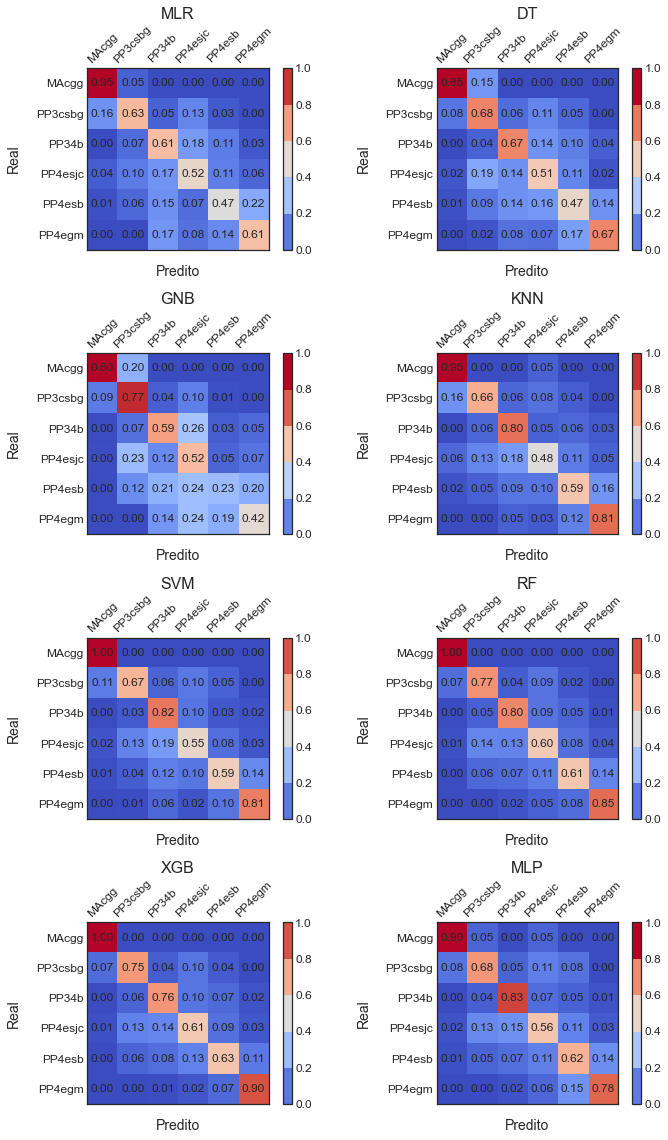

In [33]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 16))

for ax, m in zip(axs.flat, models):
    cm = confusion_matrix(y_test, dic_ŷ_test[m], normalize = 'true')
    p = ax.matshow(cm, cmap = 'coolwarm')
    fig.colorbar(p, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(str(m), size = fs_title, pad = 40)
    ax.set_xlabel('Predito', size = 14, labelpad = pad)
    ax.set_xticklabels([''] + labels, rotation = 45)
    ax.set_ylabel('Real', size = 14, labelpad = pad)
    ax.set_yticklabels([''] + labels)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.2f}'.format(z), ha = 'center', va = 'center')

plt.tight_layout()

# salva gráficos
if save_plots:
    plt.savefig("figures/notebook2/Figura_09.png", dpi = 300);

<p>
    <b>Figura 09:</b> Matrizes de confusão por modelo.
</p>

> A Formação Sopa Brumadinho (PP4esb) e a Formação São João da Chapada (PP4esjc) são as unidades mais problemáticas e, ao mesmo tempo, as classes mais frequentes na área de estudo. Tal situação era esperada, já que, duarante a separação entre os conjuntos de treino e teste, essas unidades foram intensamente subamostradas.

> A Formação Sopa Brumadinho (PP4esb) normalmente é confundida com as classes Formação São João da Chapada (PP4esjc) e Formação Galho do Miguel (PP4egm).

> A Formação São João da Chapada (PP4esjc) normalmente é confundida com as classes Formação Bandeirinha (PP34b) e Formação Barão de Guaicuí (PP3csbg).

> O modelo *XGBoost* mostra a melhor performance dentre os modelos avaliados, apresentando valores > 60% nas predições de todas as unidades.

> O modelo *Random Forest* apresenta performance similar ao *XGBoost*.

> Os modelos mais simples, como *Gaussian Naive Bayes* e *Multinomial Logistic Regression* apresentam as piores performances. Entretanto, o modelo mais complexo, *Multilayer Perceptron*, não se mostra o mais performático. Nesse sentido, parece não haver uma relação direta entre a complexidade do modelo e sua performance.  

### Métricas por unidade litoestratigráfica

Nesta seção, é gerado um report das métricas avaliadas (i.e. F1-score, recall, precisão e acurácia) por unidade litoestratigráfica.

In [34]:
for k in dic_ŷ_test.keys():
    print('---- \n')
    print(f'{k}:')
    print(classification_report(y_test, dic_ŷ_test[k]))

---- 

DUMMY:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00      2044
           3       0.00      0.00      0.00       965
           4       0.44      1.00      0.61      4739
           5       0.00      0.00      0.00      2774
           6       0.00      0.00      0.00       329

    accuracy                           0.44     10871
   macro avg       0.07      0.17      0.10     10871
weighted avg       0.19      0.44      0.26     10871

---- 

MLR:
              precision    recall  f1-score   support

           1       0.03      0.95      0.07        20
           2       0.64      0.63      0.63      2044
           3       0.30      0.61      0.40       965
           4       0.79      0.52      0.63      4739
           5       0.64      0.47      0.54      2774
           6       0.18      0.61      0.28       329

    accuracy                           0.54     108

> Todos os modelos apresentam precisão baixa nas predições do Complexo Granito-Gnáissico (unidade 1), com valores sempre inferiores à 10%.

> De forma geral, os modelos mostram baixa precisão ao predizer classes pouco frequentes na área, como Complexo Granito-Gnáissico (unidade 1) e Formação Galho do Miguel (unidade 6). Em contrapartida, essas mesmas unidades são as que apresentam os maiores valores de recall.

> Por outro lado,  tanto a Formação São João da Chapada (unidade 4) quanto a Formação Sopa Brumadinho (unidade 5), as unidades mais frequentes na área, tendem a mostrar os maiores valores de precisão e os menores valores de recall.

### Report de performance dos modelos

Nesta seção, é apresentado um report geral da performance de cada um dos modelos, levando em consideração as mesmas métricas avaliadas anteriormente (i.e. F1-score, recall, precisão e acurácia).

A função auxiliar [testReport](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Validation.py) calcula e retorna o report de performance dos modelos.

In [35]:
test_report = testReport(dic_ŷ_test, y_test)
test_report

,DUMMY,MLR,DT,GNB,KNN,SVM,RF,XGB,MLP
f1_weighted,0.265,0.576,0.566,0.502,0.607,0.637,0.676,0.675,0.643
precision_weighted,0.190,0.659,0.623,0.590,0.699,0.709,0.728,0.721,0.697
recall_weighted,0.436,0.542,0.552,0.498,0.579,0.616,0.662,0.662,0.628
accuracy,0.436,0.542,0.552,0.498,0.579,0.616,0.662,0.662,0.628


A função auxiliar [plotModelScores](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Validation.py) organiza os modelos em ordem decrescente de acordo com suas respectivas performances no conjunto de teste (*Figura 10*).

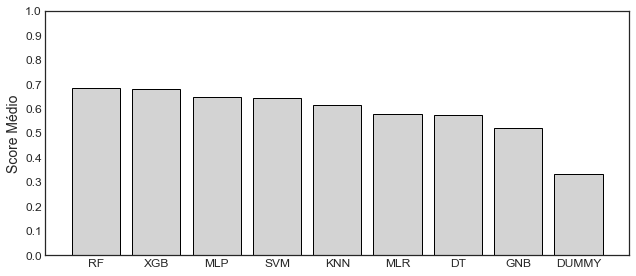

In [36]:
plotModelScores(test_report, list(tuned_models.keys()), col = col, ec = ec)

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_10.png", dpi = 300);

<p>
    <b>Figura 10:</b> Modelos organizados em ordem decrescente de acordo com a performance no conjunto de teste.
</p>

> Os modelos ensemble mostraram melhores performances. As performances de *XGBoost* e *Random Forest* são praticamente idênticas.

> Modelos simples, como *Decision Tree* e *Gausian Naive Bayes* apresentaram performances inferiores.

> O modelo mais complexo, *Multilayer Perceptron*, obteve a terceira melhor performance, sendo inferior aos modelos ensemble e superior aos demais classificadores mais simples.

> O classificador *Dummy* mostra a pior performance, conforme esperado.

<a id='12'></a>
## Avaliação do estimador do erro de generalização

Após a avaliação da performance de cada um dos modelos no conjunto de teste, é possível avaliar o desempenho do estimador do erro de generalização utilizado, a **Validação Cruzada K-Fold**.

A *Figura 11* ilustra três matrizes. A primeira delas diz respeito aos scores computados para cada um dos modelos durante a validação cruzada. A segunda matriz apresenta os scores computados durante a avaliação da performance dos modelos no conjunto de teste. Por fim, a última matriz representa a diferença entre as duas matrizes anteriores. Nesse caso, valores positivos indicam relativo otimismo por parte das estimativas, enquanto valores negativos evidenciam estimativas pessimistas para os scores.

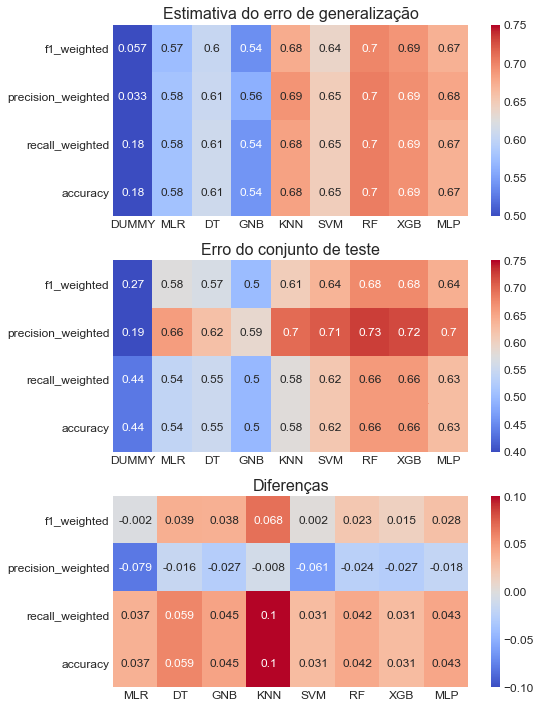

In [37]:
fig, ax = plt.subplots(3,1,figsize = (8, 10))

# heatmap de validação
sns.heatmap(val_report, cmap = 'coolwarm', annot = True, vmin = 0.5, vmax = 0.75, ax = ax[0])
ax[0].set_title('Estimativa do erro de generalização', size = fs_title)

# heatmap de teste
sns.heatmap(test_report, cmap = 'coolwarm', annot = True, vmin = 0.4, vmax = 0.75, ax = ax[1])
ax[1].set_title('Erro do conjunto de teste', size = fs_title)

# heatmap da diferença entre validação e teste
report_diff = val_report - test_report
sns.heatmap(report_diff.drop('DUMMY', axis = 1), cmap = 'coolwarm', annot = True, vmin = -0.1, vmax = 0.1, ax = ax[2])
ax[2].set_title('Diferenças', size = fs_title)

plt.tight_layout()

# salva gráficos
if save_plots:
    plt.savefig("figures/notebook2/Figura_11.png", dpi = 300);

<p>
    <b>Figura 11:</b> Matrizes de scores por modelo. A primeira matriz apresenta os scores computados durante a validação cruzada. A segunda matriz mostra os scores resultantes da avaliação de performance dos modelos no conjunto de teste. Por fim, a terceira matriz consiste nas diferenças apresentadas entre ambas as matrizes anteriores. Valores negativos indicam estimativas pessimistas, enquanto valores positivos representam estimativas relativamente otimistas.
</p>

> A Validação Cruzada K-Fold foi ligeiramente pessimista ao estimar os scores de precisão para todos os modelos. Por outro lado, essa técnica apresentou estimativas relativamente otimistas para o demais scores.

> A partir da análise da terceira matriz, nota-se que não houve diferenças (positivas ou negativas) superiores à 10%.

> Nos modelos de melhor performance, ou seja, nos modelos ensemble, as diferenças (positivas e negativas) são sempre inferiores à 4.5%

> A partir das análises realizadas ainda é difícil concluir qual classificador apresenta melhor performance: *XGBoost* ou *Random Forest*.

> A partir da comparação entre a *Figura 07* e a *Figura 10*, percebe-se que a validação cruzada apresenta um bom desempenho ao selecionar o modelo de melhor performance, considerando que a diferença entre os modelos *XGBoost* e *Random Forest* é ínfima. Entretanto, esse estimador não elencou corretamente os demais modelos em ordem decrescente de performance.

> Portanto, pode-se concluir que a Validação Cruzada K-Fold apresentou um bom desempenho como estimador do erro de generalização e como técnica de seleção do modelo de melhor performance. Enfatiza-se, entretanto, que essas conclusões não podem ser generalizadas a qualquer tipo de problema regionalizado.

<a id='13'></a>
## Mapas de probabilidade por classes

Como as performances apresentadas pelos modelos *Random Forest* e *XGBoost* foram praticamente idênticas, ambos serão comparados nas análises seguintes.

Além das predições das classes, alguns algoritmos podem realizar **predições probabilísticas** para cada uma das classes. Esse tipo de abordagem é interessante quando há um certo grau de incerteza nos dados utilizados, como é o caso deste projeto.

### Random Forest

A *Figura 12* ilustra o mapa de probabilidades para cada uma das unidades preditas pelo modelo *Random Forest*. A função auxiliar [createPredProbaTable](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Prediction.py) retorna um dataframe com as probabilidades preditas para cada uma das 6 unidades.

In [38]:
# predições probabilísticas dos conjuntos e treino e teste (RF)
pr_rf_train = tuned_models['RF'].predict_proba(X_train)
pr_rf_test  = tuned_models['RF'].predict_proba(X_test)

df_pr_rf = createPredProbaTable(pr_rf_train, pr_rf_test, train, test)

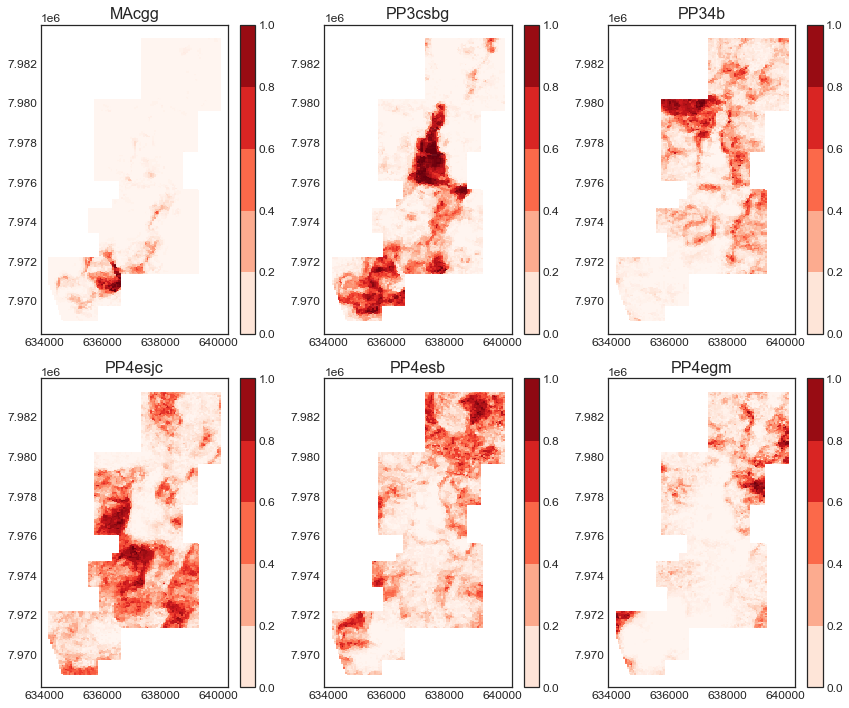

In [39]:
# mapas de probabilidade por unidade (RF)
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))

for ax, label in zip(axs.flat, labels):
    rf_pr_map = ax.scatter(data = df_pr_rf, x = 'X', y = 'Y', c = label, cmap = 'Reds', s = sz, marker = mk)
    fig.colorbar(rf_pr_map, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(label, size = fs_title)
        
plt.tight_layout()

# salva mapas
if save_plots:
    plt.savefig("figures/notebook2/Figura_12.png", dpi = 300);

<p>
    <b>Figura 12:</b> Mapas de probabilidade do modelo Random Forest para cada uma das unidades litoestratigráficas.
</p>

> O Complexo Granito-Gnáissico (MAcgg) apresenta maior probabilidade de ocorrência na porção sul da área.

> A Formação Barão de Guaicuí (PP3csbg) apresenta maior probabilidade de ocorrência nas porções central e sul da área.

> A Formação Bandeirinha (PP34b) apresenta maior probabilidade de ocorrência na porção noroeste da área.

> A Formação São João da Chapada (PP4esjc) apresenta maior probabilidade de ocorrência nas porções oeste e sudeste da área.

> A Formação Sopa Brumadinho (PP4esb) apresenta maior probabilidade de ocorrência na porção norte da área.

> A Formação Galho do Miguel (PP4egm) apresenta maior probabilidade de ocorrência nas porções sudoeste e nordeste da área.

### XGBoost

A *Figura 13* ilustra o mapa de probabilidades para cada uma das unidades preditas pelo modelo *XGBoost*. A função auxiliar [createPredProbaTable](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Prediction.py) retorna um dataframe com as probabilidades preditas para cada uma das 6 unidades.

In [40]:
# predições probabilísticas dos conjuntos de treino e teste (XGB)
pr_xgb_train = tuned_models['XGB'].predict_proba(X_train)
pr_xgb_test = tuned_models['XGB'].predict_proba(X_test)

df_pr_xgb = createPredProbaTable(pr_xgb_train, pr_xgb_test, train, test)

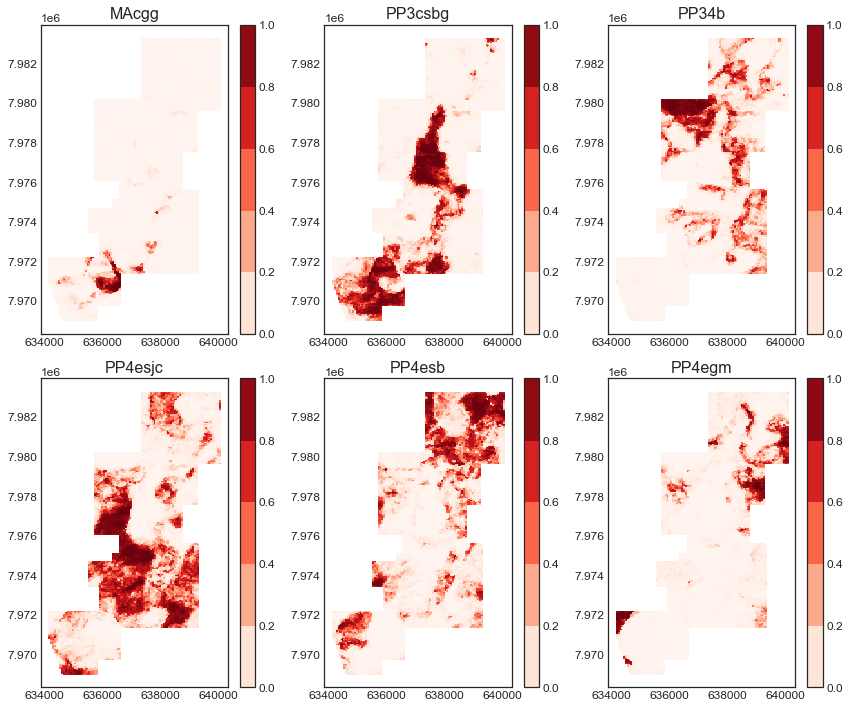

In [41]:
# mapas de probabilidade por unidade (XGB)
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))

for ax, label in zip(axs.flat, labels):
    xgb_pr_map = ax.scatter(data = df_pr_xgb, x = 'X', y = 'Y', c = label, cmap = 'Reds', s = sz, marker = mk)
    fig.colorbar(xgb_pr_map, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(label, size = fs_title)
        
plt.tight_layout()

# salva mapas
if save_plots:
    plt.savefig("figures/notebook2/Figura_13.png", dpi = 300);

<p>
    <b>Figura 13:</b> Mapas de probabilidade do modelo XGBoost para cada uma das unidades litoestratigráficas.
</p>

> As probabilidades de ocorrência para cada uma das unidades situam-se em posições semelhantes àquelas evidenciadas pelo modelo *Random Forest*.

> Entretanto, o modelo *XGBoost* aparenta ser "mais confiante" com relação às suas predições do que o modelo *Random Forest*. Isso pode ser evidenciado pelas cores "mais quentes" nos mapas de probabilidade.

<a id='14'></a>
## Mapas de entropia cruzada

De maneira geral, a **entropia cruzada** é uma função de perda (*loss function*) comumente utilizada em tarefas de classificação binárias ou multinomiais.

Imagine uma comparação entre dois classificadores binários. O classificador A tem 90% de certeza que o exemplo $x^{(i)}$ é quartzito e 10% de certeza que esse mesmo exemplo não é quartzito. Por outro lado, o classificador B tem 60% de certeza que o exemplo $x^{(i)}$ é quartzito e 40% de certeza que esse mesmo exemplo não é quartzito. Aos olhos da entropia cruzada, o classificador A é superior ao classificador B.

Como o problema em questão assume que apenas uma das classes pode ser predita para cada exemplo, um caso especial e mais simples de entropia cruzada pode ser utilizado, a **entropia cruzada categórica (H)**. Essa função é expressa pela equação abaixo, em que $x$ é a classe predita para o exemplo:

<p style="text-align:center; font-size:20px">
     $H = -log_2(q(x))$
</p>

Quanto maior é o valor da entropia cruzada, maior é a incerteza associada à predição realizada por um classificador.

A *Figura 14* ilustra os mapas de entropia cruzada categórica para os modelos *Random Forest* (esquerda) e *XGBoost* (direita). A função auxiliar [categoricalCrossEntropy](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/functions/Custom_Prediction.py) retorna um dataframe com os valores de entropia cruzada para cada uma das predições.

In [42]:
# cálculo da entropia para os modelos RF e XGB
H_rf = categoricalCrossEntropy(pr_rf_train, pr_rf_test, dic_ŷ_train['RF'], dic_ŷ_test['RF'], train, test)
H_xgb = categoricalCrossEntropy(pr_xgb_train, pr_xgb_test, dic_ŷ_train['XGB'], dic_ŷ_test['XGB'], train, test)

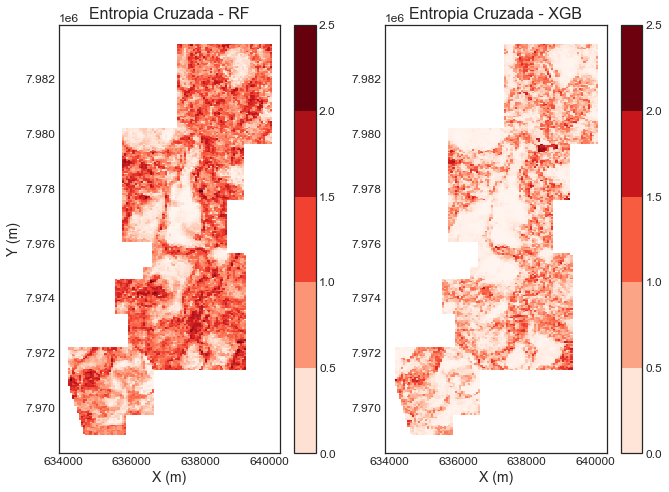

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9.5, 7))

# mapa de entropia cruzada (RF)
rf_H_map = ax1.scatter(data = H_rf, x = 'X', y = 'Y', c = 'ENTROPY', cmap = 'Reds', s = sz, marker = mk)
ax1.set_title('Entropia Cruzada - RF', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)
fig.colorbar(rf_H_map, ax = ax1, boundaries = np.linspace(0.0,2.5,6))

# mapa de entropia cruzada (XGB)
xgb_H_map = ax2.scatter(data = H_xgb, x = 'X', y = 'Y', c = 'ENTROPY', cmap = 'Reds', s = sz, marker = mk)
ax2.set_title('Entropia Cruzada - XGB', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)
fig.colorbar(xgb_H_map, ax = ax2, boundaries = np.linspace(0.0,2.5,6))

plt.tight_layout()

# salva mapas
if save_plots:
    plt.savefig("figures/notebook2/Figura_14.png", dpi = 300);

<p>
    <b>Figura 14:</b> Mapas de entropia cruzada para os modelos Random Forest (esquerda) e XGBoost (direita).
</p>

> As porções que mostram maiores valores de entropia são justamente as regiões próximas aos contatos entre as unidades litoestratigráficas.

> O mapa do modelo *Random Forest* tende a apresentar maiores valores de entropia cruzada do que o mapa do modelo *XGBoost*. Logo, *XGBoost* aparenta ser "mais confiante" em suas predições, o que já foi evidenciado na comparação entre os mapas de probabilidade.

> Portanto, tendo como referência a entropia cruzada, o modelo *XGBoost* é superior ao modelo *Random Forest*.

<a id='15'></a>
## Análise de performance: número de amostras por unidade

Por fim, o último estudo realizado consiste na análise da influência do número de instâncias amostradas por unidade na performance do modelo. Apenas o modelo *XGBoost* foi utilizado para essa análise, já que se mostrou ser o classificador mais confiante acerca de suas predições.

Para essa análise, serão comparados onze cenários, de modo que, para cada um deles, um número de instâncias por classe diferente é definido para a definição do conjunto de treino. O intuito é observar se existe algum padrão quando se aumenta o número de exemplos por classe e quais são suas implicações na performance do modelo.

In [44]:
# listas de métricas
f1s, recs, precs = [], [], []
# lista do número de amostras por unidade
samples_per_class = [50,100,150,200,250,300,350,400,500,750,1000]

for n_samp in samples_per_class:
    
    # divisão entre treino e teste
    X_train, y_train, X_test, y_test = customTrainTestSplit(df, FEAT, COORD,
                                                            samp_per_class = n_samp,
                                                            threshold = 0.7)

    # treinando o classificador
    xgb.fit(X_train, y_train)
    # predição das unidades
    ŷ = xgb.predict(X_test)
    
    # f1-score
    f1 = f1_score(y_test, ŷ, average = 'weighted')
    f1s.append(f1)
    # recall
    rec = recall_score(y_test, ŷ, average = 'weighted')
    recs.append(rec)
    # precisão
    pre = precision_score(y_test, ŷ, average = 'weighted')
    precs.append(pre)

A *Figura 15* ilustra o gráfico resultante dessa análise. Três métricas são avaliadas:

1. F1-Score (linha vermelha)
2. Recall (linha azul)
3. Precisão (linha verde)

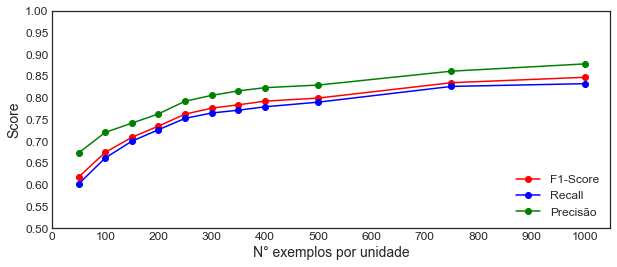

In [45]:
plt.figure(figsize = (10,4))

# f1-score
plt.plot(samples_per_class, f1s, color = 'red', marker = 'o', label = 'F1-Score')
# recall
plt.plot(samples_per_class, recs, color = 'blue', marker = 'o', label = 'Recall')
# precisão
plt.plot(samples_per_class, precs, color = 'green', marker = 'o', label = 'Precisão')

# parâmetros do gráfico
plt.xlabel('N° exemplos por unidade', size=14)
plt.xticks(np.arange(0,1050,100))
plt.ylabel('Score', size = 14)
plt.yticks(np.arange(0.5,1.05,0.05))
plt.legend(loc = 'lower right')

# salva gráfico
if save_plots:
    plt.savefig("figures/notebook2/Figura_15.png", dpi = 300);

<p>
    <b>Figura 15:</b> Avaliação do comportamento das métricas com a variação do número de amostras por unidade do conjunto de treino. F1-score é representado pela linha vermelha, recall pela linha azul e a precisão pela linha verde.
</p>

> O padrão encontrado nessa análise é, de fato, o esperado. Em outras palavras, quando se aumenta o número de instâncias amostradas por unidade, há uma melhoria na performance do modelo avaliado.

> A maior taxa de melhoria na performance do modelo ocorre entre 50 e 100 exemplos por unidade.

> Para um número de exemplos superior a 400, o ganho em performance não é muito elevado.

<a id='16'></a>
## Exportação dos resultados

Nesta seção, os resultados obtidos ao longo do trabalho são exportados para a pasta [output](https://github.com/fnaghetini/Mapa-Preditivo/tree/main/output), caso `save_results = True`. Esses dados serão utilizados em um software GIS para a confecção dos mapas finais do projeto.

In [46]:
if save_results:
    # predições realizadas por cada modelo
    pred_map.to_csv('output/out_pred.csv', header = True, index = False, float_format='%.3f')

    # predições probabilísticas (RF)
    df_pr_rf.to_csv('output/out_pred_proba_rf.csv', header = True, index = False, float_format='%.3f')
    
    # predições probabilísticas (XGB)
    df_pr_xgb.to_csv('output/out_pred_proba_xgb.csv', header = True, index = False, float_format='%.3f')
    
    # inconsistências apresentadas por cada modelo
    miss_map.to_csv('output/out_missclassif.csv', header = True, index = False, float_format='%.3f')
    
    # entropia cruzada (RF)
    H_rf.to_csv('output/out_entropy_rf.csv', header = True, index = False, float_format='%.3f')
    
    # entropia cruzada (XGB)
    H_xgb.to_csv('output/out_entropy_xgb.csv', header = True, index = False, float_format='%.3f')

Os dados atualizados (sem a feature `CT`) serão exportados (`data_nb3.csv`) para serem utilizados na explicação do modelo no [notebook3.ipynb]().

In [47]:
df.to_csv('data/data_nb3.csv', header = True, index = False)